# Feature selection (simple)

Download the fruits data [here](https://drive.google.com/file/d/1M8tiAWDZclABJN1Meq9oEHCLJTNyHdpP/view?usp=share_link)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [3]:
np.random.seed(1) #semilla global

# Load dataset
data = pd.read_csv('/content/fruits_data_ext.csv')
data.head()

,Unnamed: 0,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
0,0,1,apple,granny_smith,192.0,8.4,7.3,0.55
1,1,1,apple,granny_smith,180.0,8.0,6.8,0.59
2,2,1,apple,granny_smith,176.0,7.4,7.2,0.60
3,3,2,mandarin,mandarin,86.0,6.2,4.7,0.80
4,4,2,mandarin,mandarin,84.0,6.0,4.6,0.79


In [4]:
# X, y = data.drop(['Unnamed: 0','fruit_label','fruit_name','fruit_subtype'], axis=1), data['fruit_label']
X, y = data.iloc[:, 4:], data.iloc[:, 1]

print(X.shape, y.shape)
print(X.head())
print('-----------------')
print(y.head())

(177, 4) (177,)
    mass  width  height  color_score
0  192.0    8.4     7.3         0.55
1  180.0    8.0     6.8         0.59
2  176.0    7.4     7.2         0.60
3   86.0    6.2     4.7         0.80
4   84.0    6.0     4.6         0.79
-----------------
0    1
1    1
2    1
3    2
4    2
Name: fruit_label, dtype: int64


In [5]:
X = np.array(X)
y = np.array(y)

print(type(X), type(y), X.shape, y.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> (177, 4) (177,)


In [6]:
# Normalize data to 0-1
X = MinMaxScaler(feature_range=(0, 1)).fit_transform(X)

In [7]:
## Add some noisy data to degrade features
random_columns = np.random.permutation(22)
random_features = np.random.RandomState(1000).uniform(0, 0.5, size=(X.shape[0], 22-X.shape[1]))
X = np.hstack((X, random_features))
X = X[:, random_columns]

print (X.shape, y.shape)
print (np.arange(0,23))
print (random_columns)

(177, 22) (177,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
[19 16  3 13 18 15 10  4  2 17  6  7  1 14  0 21 20  9  8 12 11  5]


In [8]:
# Split dataset to select feature and evaluate the classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print ("\n", random_columns, "\n", np.arange(22))

(141, 22) (36, 22) (141,) (36,)

 [19 16  3 13 18 15 10  4  2 17  6  7  1 14  0 21 20  9  8 12 11  5] 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


## Classification using SVC

In [9]:
# Train a classifier using SVC on train data
svm = SVC(kernel = 'linear')
svm.fit(X_train, y_train)

SVC(kernel='linear')

Accuracy: 0.72


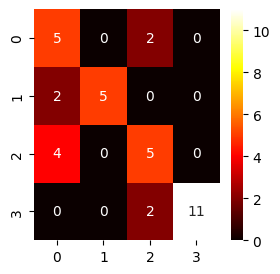

In [10]:
# Take predictions and compute some metrics (acc and CM)
predictions = svm.predict(X_test)

acc_b = accuracy_score(y_test, predictions)
cm_b = confusion_matrix(y_test, predictions)

_, ax = plt.subplots(figsize=(3,3))
sns.heatmap(cm_b, annot=True, cmap='hot', ax=ax)
print (f'Accuracy: {round(acc_b, 2)}')

## Use Recursive Feature Elimination

### RFE -> [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE)


In [12]:
from sklearn.feature_selection import RFE

# Create a new SVC classifier
clf = SVC(kernel = 'linear')

# Compute RFE
rfe = RFE( estimator = clf , n_features_to_select = 4 )

best_features = rfe.fit( X_train , y_train )


In [13]:
# See results
print("Num Features: %d" % best_features.n_features_)
print("Selected Features: %s" % best_features.ranking_)
print("                 : %s" % np.arange(22))
print("Random order     : %s" % random_columns)
# print("Original order   : %s" % np.arange(22))

Num Features: 4
Selected Features: [17  5  1  6 19  4 12 15  1  9 13 14  1 10  1 18  7 16  3  8 11  2]
                 : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Random order     : [19 16  3 13 18 15 10  4  2 17  6  7  1 14  0 21 20  9  8 12 11  5]


In [14]:
list_best = np.where(best_features.ranking_ == 1)[0].tolist()
print (list_best)

[2, 8, 12, 14]


In [15]:
# Select best features
best_train = X_train[:, list_best]
best_test  = X_test[:, list_best]

print(best_train.shape, best_test.shape)

(141, 4) (36, 4)


In [16]:
# Retrain classifier on best features and make predictions
svm = SVC(kernel = 'linear')
svm.fit(best_train, y_train)

SVC(kernel='linear')

For Recursive feature elimination
Accuracy before: 0.72
Accuracy after: 0.75


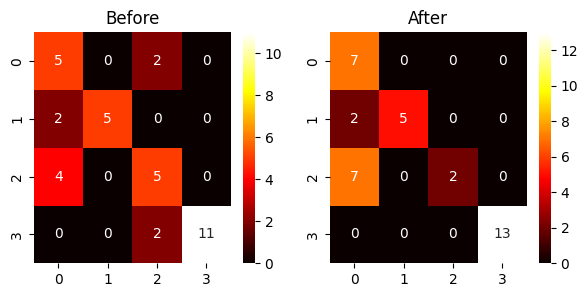

In [17]:
# Compute metrics
predictions = svm.predict(best_test)
acc_best = accuracy_score(y_test, predictions)
cm_best  = confusion_matrix(y_test, predictions)

print("For Recursive feature elimination")
_, axes = plt.subplots(1, 2, figsize=(7,3))
sns.heatmap(cm_b, annot=True, cmap='hot', ax=axes[0])
sns.heatmap(cm_best, annot=True, cmap='hot', ax=axes[1])
axes[0].set_title('Before'), axes[1].set_title('After')

print(f'Accuracy before: {round(acc_b, 2)}\nAccuracy after: {round(acc_best, 2)}')

## Use univariate selection to determine best features


### SelectKBest -> [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest)

Metrics: [F_classif (ANOVA)](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.f_classif), [Chi2](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html#sklearn.feature_selection.chi2), [mutual_information](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html#sklearn.feature_selection.mutual_info_classif)

In [18]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2 #ANOVA

skb = SelectKBest( f_classif , k = 4 )
skb.fit( X_train , y_train )

SelectKBest(k=4)

In [19]:
print(np.array(skb.get_support(), dtype=int))
selected_features = skb.get_support()

[0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0]


In [20]:
best_train = X_train[:, selected_features]
best_test = X_test[:, selected_features]

print (best_train.shape)

(141, 4)


In [21]:
print("Num Features: %d" % best_train.shape[0])
print("Selected Features: %s" % np.array(skb.get_support(),dtype=int).tolist())
print("                 : %s" % np.arange(22))
print("Random order     : %s" % random_columns)
print("Original order   : %s" % np.arange(22))

Num Features: 141
Selected Features: [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]
                 : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Random order     : [19 16  3 13 18 15 10  4  2 17  6  7  1 14  0 21 20  9  8 12 11  5]
Original order   : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


In [22]:
# Retrain classifier on best features and make predictions
clf = SVC(kernel = 'linear')
clf.fit(best_train, y_train)

SVC(kernel='linear')

For Recursive feature elimination
Acc Before: 0.72
Acc After: 0.75


<Axes: >

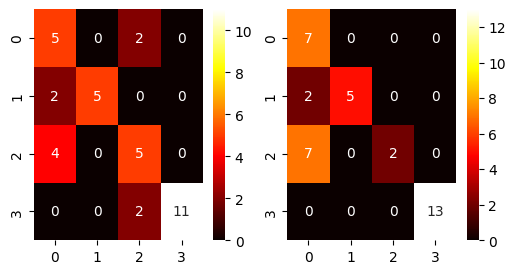

In [23]:
# Compute metrics
predictions = clf.predict(best_test)
acc_best = accuracy_score(y_test, predictions)
cm_best  = confusion_matrix(y_test, predictions)

print("For Recursive feature elimination")
print(f'Acc Before: {round(acc_b, 2)}\nAcc After: {round(acc_best, 2)}')

_, axes = plt.subplots(1, 2, figsize=(6,3))
sns.heatmap(cm_b, annot=True, cmap='hot', ax=axes[0])
sns.heatmap(cm_best, annot=True, cmap='hot', ax=axes[1])

### SelectPercentile -> [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html#sklearn.feature_selection.SelectPercentile)

In [31]:
from sklearn.feature_selection import SelectPercentile, f_classif, chi2 #ANOVA

spc = SelectPercentile( f_classif , percentile = 20 )
spc.fit( X_train , y_train )

best_train = X_train[:, spc.get_support()]
best_test = X_test[:, spc.get_support()]

print (best_train.shape)

(141, 5)


In [32]:
print("Num Features: %d" % best_train.shape[0])
print("Selected Features: %s" % np.array(spc.get_support(), dtype=int))
print("                 : %s" % np.arange(22))
print("                 : %s" % random_columns)

Num Features: 141
Selected Features: [0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0]
                 : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
                 : [19 16  3 13 18 15 10  4  2 17  6  7  1 14  0 21 20  9  8 12 11  5]


In [ ]:
# Retrain classifier on best features and make predictions



In [ ]:
# Compute metrics
acc_best =
cm_best  =

print("For Recursive feature elimination")



## Use Metatransformer to determine best features

### SelectFromModel -> [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel)

In [38]:
from sklearn.feature_selection import SelectFromModel

# Create a new SVC classifier
clf = SVC(kernel = 'linear')

# Compute metatransformer
sfm = SelectFromModel(estimator = clf, max_features = 11)

best_features = sfm.fit(X_train, y_train)

In [40]:
# Transform best features
best_train = X_train[:, sfm.get_support()]
best_test  = X_test[:, sfm.get_support()]

print(best_train.shape, best_test.shape)

(141, 4) (36, 4)


In [39]:
print("Num Features: %d" % sfm.n_features_in_)
print("Selected Features: %s" % np.array(sfm.get_support(), dtype=int))
print("                 : %s" % np.arange(22))
print("                 : %s" % random_columns)

Num Features: 22
Selected Features: [0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0]
                 : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
                 : [19 16  3 13 18 15 10  4  2 17  6  7  1 14  0 21 20  9  8 12 11  5]


In [41]:
# Retrain classifier on best features and make predictions
svm = SVC(kernel = 'linear')
svm.fit(best_train, y_train)

SVC(kernel='linear')

For Recursive feature elimination
Acc Before: 0.72
Acc After: 0.75


<Axes: >

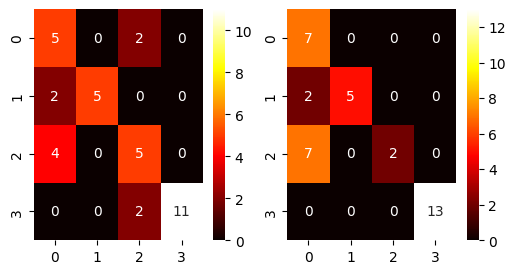

In [42]:
# Compute metrics
predictions = svm.predict(best_test)
acc_best = accuracy_score(y_test, predictions)
cm_best  = confusion_matrix(y_test, predictions)

print("For Recursive feature elimination")
print(f'Acc Before: {round(acc_b, 2)}\nAcc After: {round(acc_best, 2)}')

_, axes = plt.subplots(1, 2, figsize=(6,3))
sns.heatmap(cm_b, annot=True, cmap='hot', ax=axes[0])
sns.heatmap(cm_best, annot=True, cmap='hot', ax=axes[1])